In [ ]:
!pip install torch~=2.5.0 torch_xla[tpu]~=2.5.0 -f https://storage.googleapis.com/libtpu-releases/index.html

In [40]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
# import torch_xla
# import torch_xla.core.xla_model as xm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import re

from sklearn.model_selection import train_test_split


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [41]:
# device = xm.xla_device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [42]:
url = 'https://www.gutenberg.org/files/1661/1661-0.txt'
df = pd.read_fwf(url, header=None)

text = " ".join(df[0].dropna().tolist()) # Concatenating all lines into a single string
cleaned_text = re.sub(r'[^A-Za-z0-9 ,.]', '', text) # Remove everything except alphanumeric characters, spaces, commas, and full-stops

# Replace sentence-ending periods that are followed by a space and a capital letter
abbreviation_pattern = r'\b(Mr|Mrs|Dr)\.' # Only replace periods not followed by common abbreviations
sentence_end_pattern = r'\. +(?=[A-Z])'  # Period followed by a space and a capital letter

# First, replace periods in abbreviations with a placeholder (if necessary)
cleaned_text = re.sub(abbreviation_pattern, r'\1 <ABBR>', cleaned_text)

# Then, replace sentence-ending periods with a special delimiter
cleaned_text = re.sub(sentence_end_pattern, ' [SENTENCE] ', cleaned_text)

# Replace the placeholder back to period
cleaned_text = cleaned_text.replace('<ABBR>', '.')
cleaned_text = cleaned_text.lower()

# Split the text into sentences using the special delimiter
sentences = [sentence.strip() for sentence in cleaned_text.split('[SENTENCE]'.lower()) if sentence]

# Display the first few sentences to verify
sentences = sentences[17:]
print(sentences[:5])


['to sherlock holmes she is always the woman', 'i have seldom heard him mention her under any other name', 'in his eyes she eclipses and predominates the whole of her sex', 'it was not that he felt any emotion akin to love for irene adler', 'all emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind']


In [4]:
# Function to create vocabulary
def create_vocab(text):
    tokens = text.split()  # Split the text by spaces
    vocab = {}  # Initialize an empty dictionary for word frequency
    for token in tokens:
        if token in vocab:
            vocab[token] += 1  # Increment count if word already exists
        else:
            vocab[token] = 1  # Initialize count if it's a new word

    # Create word2idx and idx2word mappings
    word2idx = {word: idx for idx, word in enumerate(vocab.keys())}
    idx2word = {idx: word for word, idx in word2idx.items()}

    return word2idx, idx2word

# Create the vocabulary from the cleaned text
word2idx, idx2word = create_vocab(cleaned_text)
vocab_size = len(word2idx)
print(f"Vocabulary Size: {vocab_size}")  # Display vocabulary size

Vocabulary Size: 10742


In [5]:
# Create input-output pairs based on the cleaned text and vocabulary
def create_sequences_from_sentences(sentences, word2idx, context_length):
    X, y = [], []

    for sentence in sentences:
        words = sentence.split()  # Split the sentence into words
        for i in range(len(words) - context_length):
            context = words[i:i + context_length]  # Get 'context_length' words
            target = words[i + context_length]  # The next word is the target
            X.append([word2idx[word] for word in context])  # Convert words to indices
            y.append(word2idx[target])  # Convert target word to index

    return np.array(X), np.array(y)

context_length = 5  # The number of previous words used to predict the next word
X, y = create_sequences_from_sentences(sentences, word2idx, context_length)

print(f"Input shape: {X.shape}, Output shape: {y.shape}")


Input shape: (79046, 5), Output shape: (79046,)


In [60]:
# Model parameters
embedding_dim = 32  # Embedding vector size
hidden_layer_size = 512
vocab_size = len(word2idx)  # Size of the vocabulary
context_length = 5  # Number of words used as context (matches input sequence length)

In [66]:
# Define the MLP model using PyTorch
class WordPredictionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_layer_size, context_length):
        super(WordPredictionModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(embedding_dim * context_length, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.output = nn.Linear(hidden_layer_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # Get the embeddings
        x = self.flatten(x)  # Flatten the output
        x = torch.tanh(self.fc1(x))  # First hidden layer
        x = torch.tanh(self.fc2(x))  # Second hidden layer
        x = torch.tanh(self.fc3(x))  # Third hidden layer
        x = self.output(x)  # Output layer
        return x

# Instantiate the model
model = WordPredictionModel(vocab_size, embedding_dim, hidden_layer_size, context_length)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Print the model summary (custom function)
def print_model_summary(model):
    print(model)

# Display model summary
print_model_summary(model)


WordPredictionModel(
  (embedding): Embedding(10742, 32)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=160, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10742, bias=True)
)


In [67]:
# Convert X and y to tensors
X_tensor = torch.tensor(X, dtype=torch.long)  # Assuming X is your input tensor (context)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y is your output tensor (target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor.numpy(), y_tensor.numpy(), test_size=0.2, random_state=42)

# Convert back to tensors after splitting
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define training parameters
epochs = 500  # Set the number of epochs based on your hardware capability
batch_size = 256

# Initialize the model, loss function, and optimizer
model = WordPredictionModel(vocab_size, embedding_dim, hidden_layer_size, context_length)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Function to train the model
def train_model(model, criterion, optimizer, X_train, y_train, epochs, batch_size):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            # Get the batch
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)

            # Compute loss
            loss = criterion(outputs, y_batch)

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

        # Print the loss for this epoch
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


In [68]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():

        outputs = model(X_test)
        probas = F.softmax(outputs,dim=1)

        predicted = probas.multinomial(num_samples=1, replacement=True)

        #_, predicted = torch.max(outputs, 1)  # Get predicted classes

        accuracy = (predicted == y_test).sum().item() / len(y_test)  # Calculate accuracy
    return accuracy

In [ ]:
# Train the model
train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs, batch_size)

In [50]:
test_accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

(10742, 2)


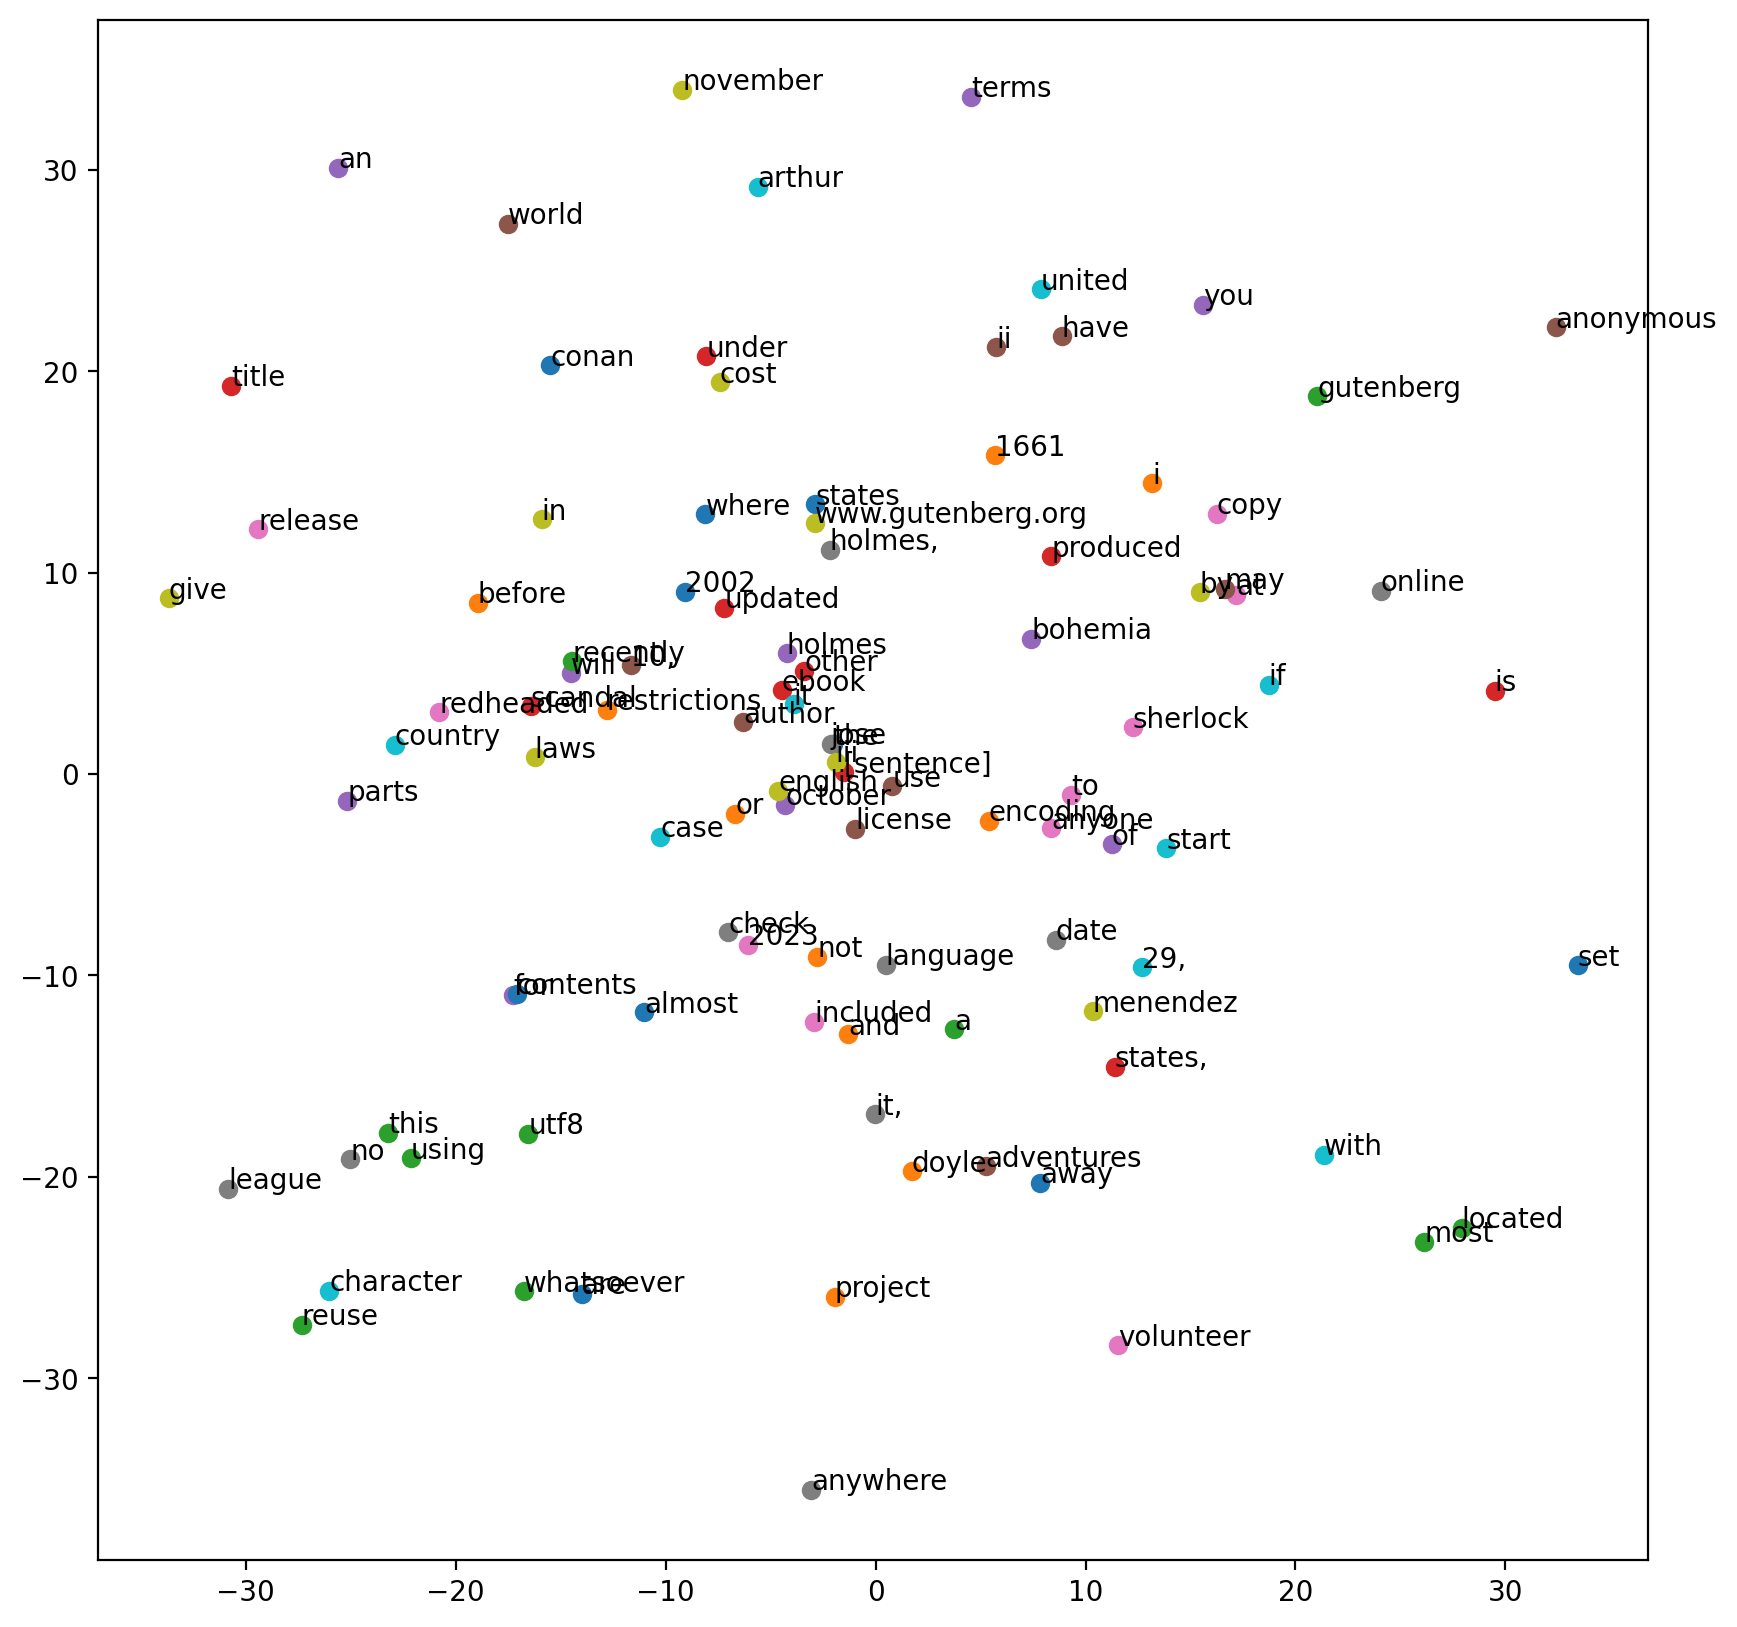

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the embeddings from the embedding layer
embedding_layer = model.embedding
embeddings = embedding_layer.weight.data  # .data to get the tensor data

# Use t-SNE to reduce the dimensionality of the embeddings for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)
print(reduced_embeddings.shape)


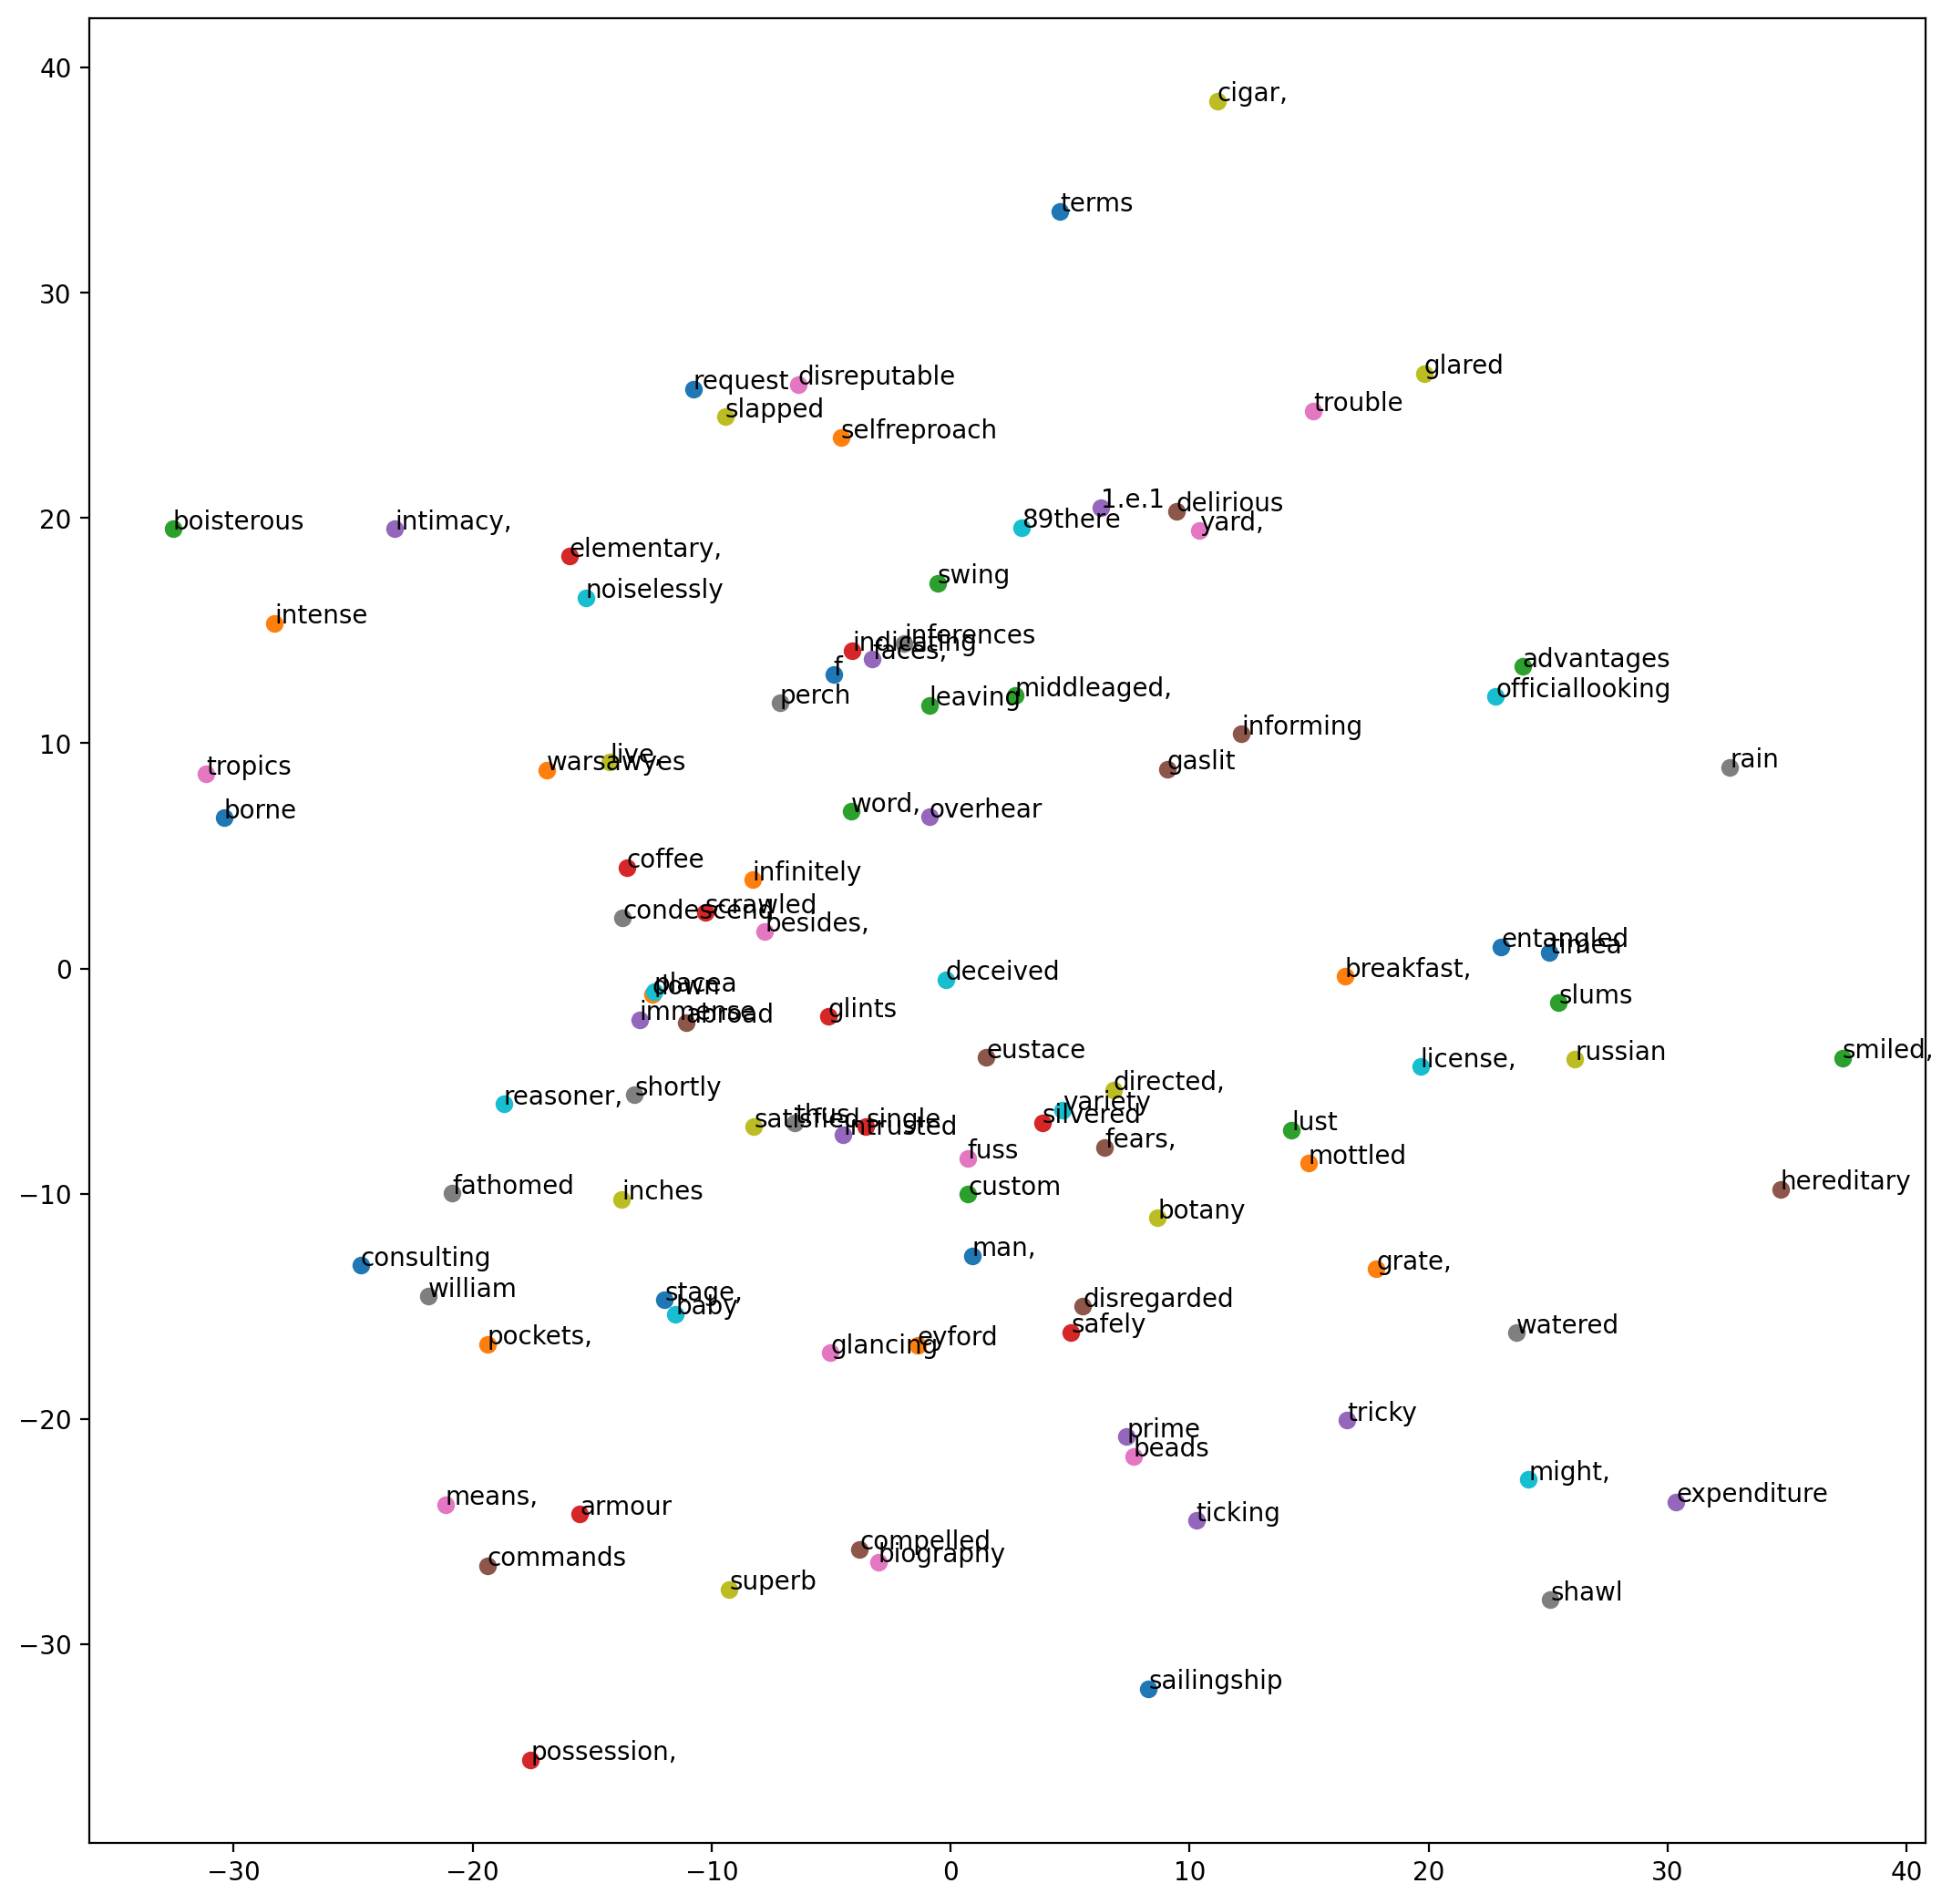

In [56]:
# Plot the embeddings (you can plot the top N words)
plt.figure(figsize=(13,13))

num_words_to_display = 100

selected_values = np.random.choice(np.arange(reduced_embeddings.shape[0]), size=num_words_to_display, replace=False)

for i in selected_values:
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.annotate(idx2word[i], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.show()

In [57]:
# Predict the next word based on a given context
def predict_next_word(model, context, word2idx, idx2word):
    context_seq = [word2idx[word] for word in context.split()[-context_length:]]  # Convert context to indices
    context_seq = torch.tensor(context_seq, dtype=torch.long).unsqueeze(0)  # Convert to PyTorch tensor and reshape
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        probas = F.softmax(model(context_seq),dim=1)
    predicted_idx = probas.multinomial(num_samples=1, replacement=True).item()
    return idx2word[predicted_idx]

In [58]:
# Example prediction
context_length = 5  # Or whatever your context length is
context = input().lower()
context = " ".join(context.split()[len(context.split())-5:len(context.split())])
# Assuming context_length is defined somewhere in your code
# If not, define it before calling predict_next_word

s = context
print(s,end="")
for i in range(50):
  next_word = predict_next_word(model, context, word2idx, idx2word)
  s += f" {next_word}"
  context = " ".join(s.split()[len(s.split())-6:len(s.split())])
  print(f" {next_word}",end="")

sherlock holmes is a very
sherlock holmes is a very sudden trap i left the sound which can speak their remember a angle line, i should disturb i have felt a reason more than has easterly retired passing care when i got a man following there is your needed that he is england, for that night which had been natural